In [178]:
import numpy as np
from PIL import Image
import os
import time
import math
import matplotlib.pyplot as plt

## Pre-procesamiento de imágenes

Función para convertir imágenes a vectores normalizados en escala de grises:

In [179]:
def image_convert(dir, new_size):

    imagenes = []

    for filename in os.listdir(dir):

        file_path = os.path.join(dir, filename)
        
        if os.path.isfile(file_path):

            # Sin este if no funciona en mi windows, probar comentarlo en Mac a ver que pasa
            if not filename.lower().endswith('.png'):
                continue
            try:
                with Image.open(file_path) as img:
                    img = img.resize(new_size) 
                    img = img.convert('L')
                    img_array = np.array(img)/255.0
                    img_vector = img_array.reshape((new_size[0]**2)) 
                    imagenes.append(img_vector)
            except Exception as e:
                print(f"Error {file_path}: {e}")

    return np.array(imagenes)


Configuramos los tamaños y elegimos aquel que se utilizará para los experimentos:

In [180]:
original = (256, 256)
mediano =  (128, 128)
chico = (64, 64)
muy_chico = (32, 32)

size = mediano

In [181]:
# Healthy
src_dir = 'DatasetTP/Healthy'
i_healthy = image_convert(src_dir, size) # Imágenes de pacientes sanos
d_healthy = np.ones((i_healthy.shape[0], 1)) * 0 # Vector de diagnósticos para la gente sana (0)

# Parkinson
src_dir = 'DatasetTP/Parkinson'  
i_park = image_convert(src_dir, size) # Imágenes de pacientes con Parkinson
d_park = np.ones((i_park.shape[0], 1)) # Vector de diagnósticos para la gente con Parkinson (1)

cant_healthy = i_healthy.shape[0] # Cantidad de imágenes sanas
print(f"Cantidad de imágenes sanas: {cant_healthy}")

cant_park = i_park.shape[0] # Cantidad de imágenes con Parkinson
print(f"Cantidad de imágenes con Parkinson: {cant_park}")

print(f"Tamaño de las imágenes: {size} = {size[0] * size[1]} pixeles")

Cantidad de imágenes sanas: 816
Cantidad de imágenes con Parkinson: 816
Tamaño de las imágenes: (128, 128) = 16384 pixeles


Separamos en conjuntos de entrenamiento y test:

In [182]:
cant_healthy_train = round(cant_healthy * 0.5) 
cant_healthy_test = cant_healthy - cant_healthy_train 

cant_park_train = round(cant_park * 0.5) 
cant_park_test = cant_park - cant_park_train 

# Dividimos las imágenes en entrenamiento y test
i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train])) # Imágenes de entrenamiento
d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train])) # Diagnósticos de entrenamiento

i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:])) # Imágenes de test
d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:])) # Diagnósticos de test

print(f"Entrenamiento: {i_train.shape}, {d_train.shape}")
print(f"Test: {i_test.shape}, {d_test.shape}")

# Mezclo los datos de entrenamiento y test
np.random.seed(42)  
indices = np.random.permutation(i_train.shape[0])
i_train = i_train[indices]
d_train = d_train[indices]

indices = np.random.permutation(i_test.shape[0])
i_test = i_test[indices]
d_test = d_test[indices]

# Chequeamos que la intersección entre train y test sea nula (Importante)
print(f"Intersección entre los conjuntos igual a cero: {len(set(map(tuple, i_train)).intersection(map(tuple, i_test))) == 0}")


Entrenamiento: (816, 16384), (816, 1)
Test: (816, 16384), (816, 1)
Intersección entre los conjuntos igual a cero: True


## Parte 1: Descenso de gradiente

Funciones base:

In [183]:
def fwb_desc(i, w, b):
    z = i@w + b 
    f = (np.tanh(z) + 1) / 2 
    return f 

In [184]:
# Error cuadrático
def funcion_objetivo_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    rss = np.sum((f - d) ** 2)
    return rss

In [185]:
# Derivada parcial respecto a w
def df_w_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    z = i @ w + b
    dz = (1 - np.tanh(z) ** 2) * (f - d)  
    grad_w = i.T @ dz                  
    return grad_w

In [186]:
# Derivada parcial respecto a b
def df_b_desc(w, b, i, d):
    f = fwb_desc(i, w, b)
    z = i @ w + b
    dz = (1 - np.tanh(z) ** 2) * (f - d)
    # grad_b = np.sum(dz, axis=0, keepdims=True)  # Da forma (1,1)
    grad_b = np.sum(dz) 
    return grad_b

In [187]:
def accuracy_desc(i, d, w, b):
    f = fwb_desc(i, w, b) 
    y_hat = (f >= 0.5).astype(int)  
    d = d.astype(int)  
    return np.mean(y_hat == d) * 100  

### Método de descenso por gradiente

In [188]:
MAX_ITER = 1000

TOLERANCIA = 1e-8

def gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar):
    
  if normalizar:
    i_train = i_train / 255.0
    i_test = i_test / 255.0

  iter  = 0
  valores_loss_train = [] 
  valores_loss_test = []
  accuracy_train = []
  accuracy_test = []


  while iter <= MAX_ITER:

    valores_loss_train.append(funcion_objetivo_desc(w, b, i_train, d_train))
    valores_loss_test.append(funcion_objetivo_desc(w, b, i_test, d_test))

    # Calcular accuracy sobre test (podés hacer también sobre train si querés)
    acc_train = accuracy_desc(i_train, d_train, w, b)
    acc_test = accuracy_desc(i_test, d_test, w, b)
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
        
    gradiente_w = df_w_desc(w, b, i_train, d_train) 
    gradiente_b = df_b_desc(w, b, i_train, d_train)

    # Actualización 
    w_sig = w - alpha * gradiente_w
    b_sig = b - alpha * gradiente_b

    # Criterio de convergencia
    criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, i_train, d_train) - funcion_objetivo_desc(w, b, i_train, d_train))

    if criterio < TOLERANCIA:
      print("Criterio de convergencia alcanzado en iteración", iter)
      break

    w = w_sig
    b = b_sig
    iter += 1

  return w_sig, b_sig, valores_loss_train, valores_loss_test, accuracy_train, accuracy_test


### Seteo de parámetros y aplicación del gradiente descendiente

In [189]:
w = np.random.uniform(-1, 1, (i_train[0].shape[0], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-7
normalizar = False
w_no_norm_train, b_no_norm_train, loss_no_norm_train, loss_no_norm_test, acc_train_no_norm, acc_test_no_norm = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)
# w_no_norm_test, b_no_norm_test, loss_no_norm_test, accuracy_no_norm_test = gradient_descent(w, b, i_test, d_test, alpha, normalizar)

# normalizar = True
# w_norm_train, b_norm_train, loss_norm_train, accuracy_norm_train = gradient_descent(w, b, i_train, d_train, alpha, normalizar)

# w_norm_test, b_norm_test, loss_norm_test, accuracy_norm_test = gradient_descent(w, b, i_test, d_test, alpha, normalizar)



In [190]:
normalizar = True
w_norm_train, b_norm_train, loss_norm_train, loss_norm_test, acc_train_norm, acc_test_norm = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)

In [191]:
# print(f"Máxima accuracy en entrenamiento: {max(accuracy_train)}")
# print(f"Mínima accuracy en entrenamiento: {min(accuracy_train)}")

In [192]:
# # Usando Matplot
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Datos del eje x (iteraciones)
# iteraciones_loss = np.arange(1, len(valores_loss_train) + 1)
# iteraciones_acc = np.arange(1, len(accuracy_train) + 1)

# # --- Subgráfico 1: Error Cuadrático ---
# axes[0].plot(np.arange(1, len(valores_loss_train)+1), valores_loss_train, color='steelblue', linewidth=2, label='Error Cuadrático')
# axes[0].set_title('Error Cuadrático - Train', fontsize=16, fontweight='bold')
# axes[0].set_xlabel('Iteración', fontsize=14)
# axes[0].set_ylabel('Error Cuadrático', fontsize=14)
# axes[0].legend(fontsize=12)
# axes[0].grid(True, linestyle='--', alpha=0.6)

# # --- Subgráfico 2: Accuracy ---
# axes[1].plot(np.arange(1, len(accuracy_train)+1), accuracy_train, color='darkorange', linewidth=2, label='Accuracy')
# axes[1].set_title('Accuracy - Train', fontsize=16, fontweight='bold')
# axes[1].set_xlabel('Iteración', fontsize=14)
# axes[1].set_ylabel('Accuracy', fontsize=14)
# axes[1].legend(fontsize=12)
# axes[1].grid(True, linestyle='--', alpha=0.6)

# plt.tight_layout()
# plt.show()

## Experimentos

In [193]:
# # sns.set_style("whitegrid")
# # fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # # Error cuadrático
# # sns.lineplot(x=np.arange(1, len(valores_loss_test)+1), y=valores_loss_test, ax=axes[0], color='steelblue', linewidth=2, label='Error Cuadrático')
# # axes[0].set_title('Error Cuadrático - Test', fontsize=16, weight='bold')
# # axes[0].set_xlabel('Iteración', fontsize=14)
# # axes[0].set_ylabel('Error Cuadrático', fontsize=14)
# # axes[0].legend(fontsize=12)

# # # Accuracy
# # sns.lineplot(x=np.arange(1, len(accuracy_test)+1), y=accuracy_test, ax=axes[1], color='darkorange', linewidth=2, label='Accuracy')
# # axes[1].set_title('Accuracy - Test', fontsize=16, weight='bold')
# # axes[1].set_xlabel('Iteración', fontsize=14)
# # axes[1].set_ylabel('Accuracy', fontsize=14)
# # axes[1].legend(fontsize=12)

# # plt.tight_layout()
# # plt.show()

# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Eje x para cada métrica
# iteraciones_loss = np.arange(1, len(valores_loss_test) + 1)
# iteraciones_acc = np.arange(1, len(accuracy_test) + 1)

# # --- Subgráfico 1: Error Cuadrático - Test ---
# axes[0].plot(np.arange(1, len(valores_loss_test)+1), valores_loss_test, color='steelblue', linewidth=2, label='Error Cuadrático')
# axes[0].set_title('Error Cuadrático - Test', fontsize=16, fontweight='bold')
# axes[0].set_xlabel('Iteración', fontsize=14)
# axes[0].set_ylabel('Error Cuadrático', fontsize=14)
# axes[0].grid(True, linestyle='--', alpha=0.6)
# axes[0].legend(fontsize=12)

# # --- Subgráfico 2: Accuracy - Test ---
# axes[1].plot(np.arange(1, len(accuracy_test)+1), accuracy_test, color='darkorange', linewidth=2, label='Accuracy')
# axes[1].set_title('Accuracy - Test', fontsize=16, fontweight='bold')
# axes[1].set_xlabel('Iteración', fontsize=14)
# axes[1].set_ylabel('Accuracy', fontsize=14)
# axes[1].grid(True, linestyle='--', alpha=0.6)
# axes[1].legend(fontsize=12)

# plt.tight_layout()
# plt.show()

Análisis de normalización

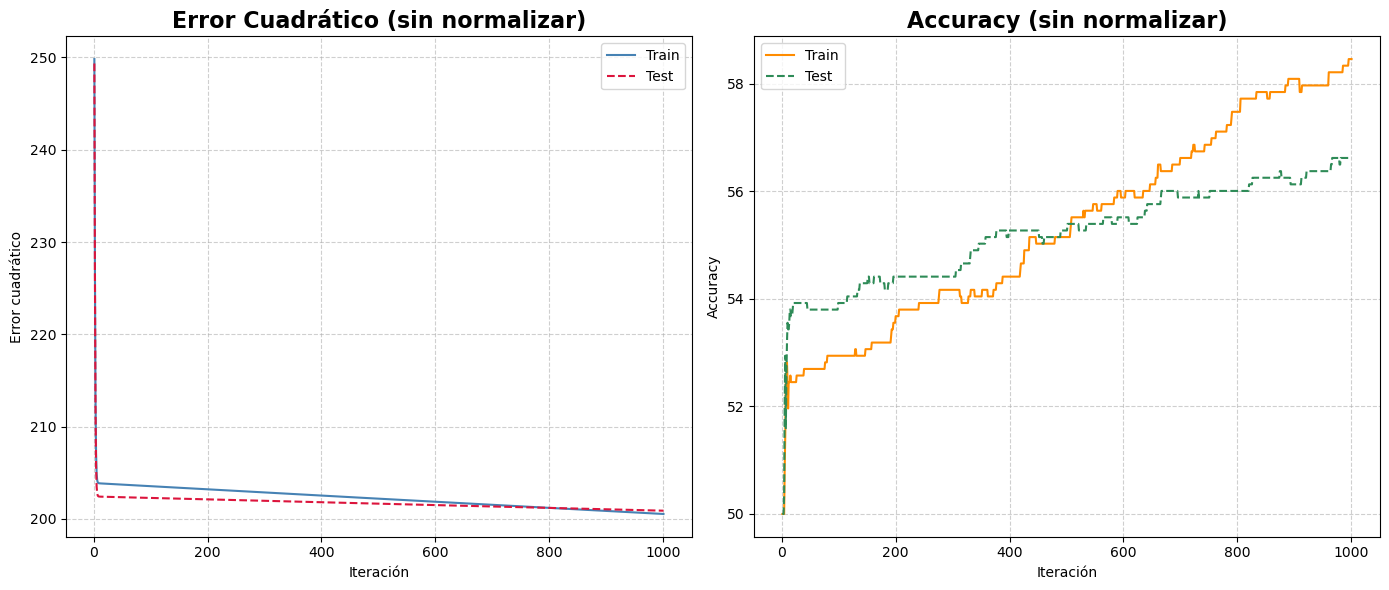

In [194]:
# SIN NORMALIZAR 
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Eje x: iteraciones
iter_train_no_norm = np.arange(1, len(loss_no_norm_train) + 1)

# --- Error cuadrático sin normalizar ---
axes[0].plot(iter_train_no_norm, loss_no_norm_train, label='Train', color='steelblue')
axes[0].plot(iter_train_no_norm, loss_no_norm_test, label='Test', color='crimson', linestyle='--')
axes[0].set_title('Error Cuadrático (sin normalizar)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('Error cuadrático')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Accuracy sin normalizar ---
axes[1].plot(iter_train_no_norm, acc_train_no_norm, label='Train', color='darkorange')
axes[1].plot(iter_train_no_norm, acc_test_no_norm, label='Test', color='seagreen', linestyle='--')
axes[1].set_title('Accuracy (sin normalizar)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

Probemos ahora con datos normalizados:

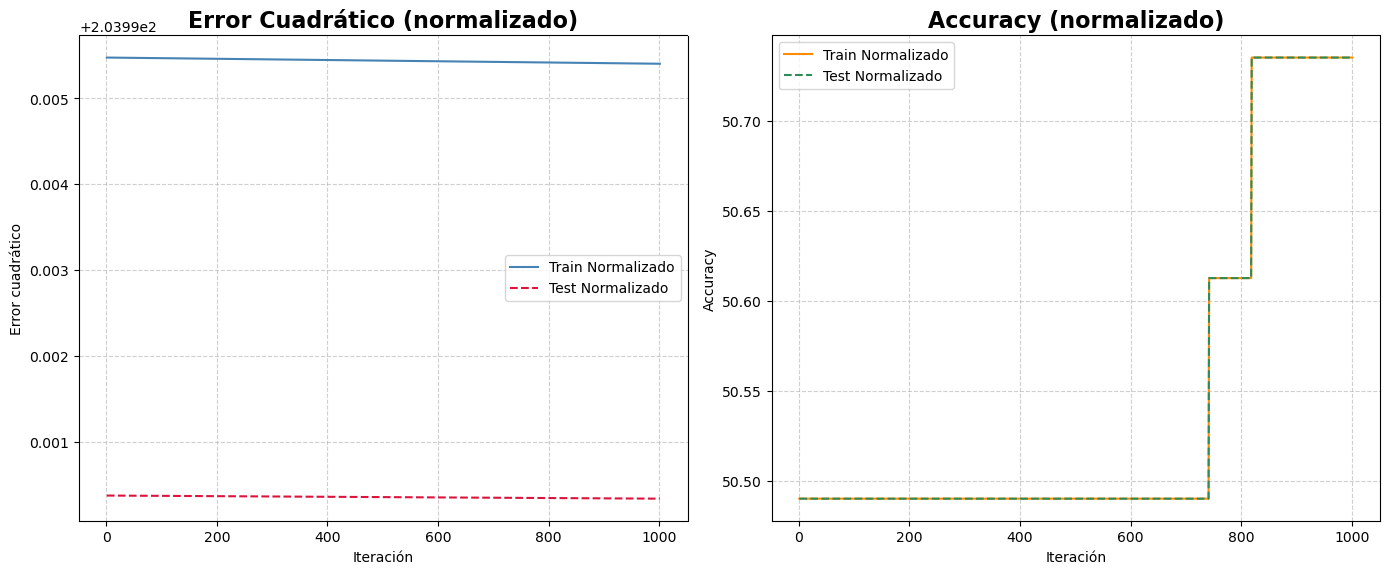

In [195]:
# CON NORMALIZAR

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

iter_train_norm = np.arange(1, len(loss_norm_train) + 1)

# --- Error cuadrático normalizado ---
axes[0].plot(iter_train_norm, loss_norm_train, label='Train Normalizado', color='steelblue')
axes[0].plot(iter_train_norm, loss_norm_test, label='Test Normalizado', color='crimson', linestyle='--')
# axes[0].plot(iter_train_no_norm, loss_no_norm_train, label='Train No Normalizado', color='violet')
# axes[0].plot(iter_train_no_norm, loss_no_norm_test, label='Test No Normalizado', color='green', linestyle='--')
axes[0].set_title('Error Cuadrático (normalizado)', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Iteración')
axes[0].set_ylabel('Error cuadrático')
axes[0].legend()
axes[0].grid(True, linestyle='--', alpha=0.6)

# --- Accuracy normalizado ---
axes[1].plot(iter_train_norm, acc_train_norm, label='Train Normalizado', color='darkorange')
axes[1].plot(iter_train_norm, acc_train_norm, label='Test Normalizado', color='seagreen', linestyle='--')
axes[1].set_title('Accuracy (normalizado)', fontsize=16, fontweight='bold')
axes[1].set_xlabel('Iteración')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [196]:
# plt.figure(figsize=(12, 6))
# sns.set_style("whitegrid")  
# iteraciones = np.arange(1, len(valores_loss_test) + 1)
# sns.lineplot(x=iteraciones, y=valores_loss_test, color='seagreen', linewidth=2, markersize=5)
# tick_interval = max(1, len(valores_loss_test) // 20)
# plt.xticks(np.arange(1, len(valores_loss_test) + 1, step=tick_interval))
# plt.xlabel('Iteración', fontsize=14)
# plt.ylabel('Valor de la función objetivo', fontsize=14)
# plt.title('Convergencia de GD con datos de test', fontsize=16, weight='bold')
# plt.legend(['Función objetivo (loss)'], fontsize=12)
# plt.tight_layout()
# plt.show()

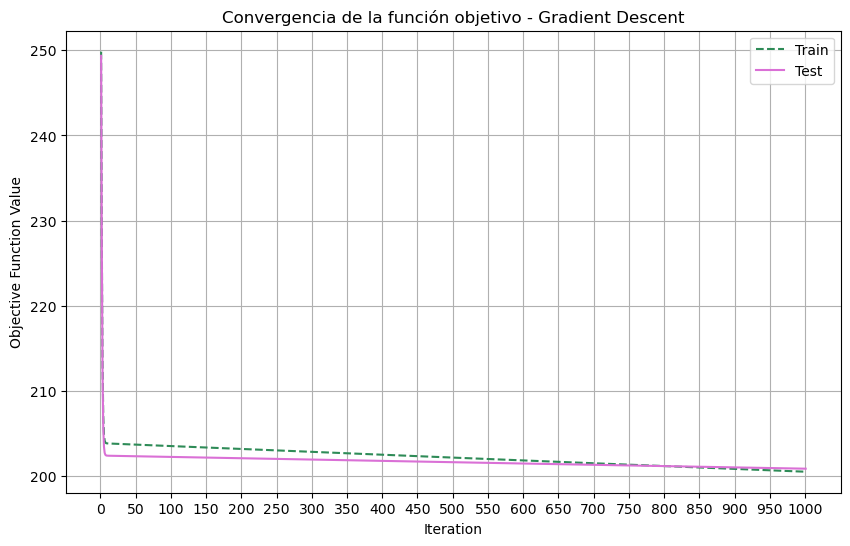

In [197]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(loss_no_norm_train) + 1), loss_no_norm_train, linestyle='--', color='seagreen', label='Train')

plt.plot(np.arange(1, len(loss_no_norm_test) + 1), loss_no_norm_test, linestyle='-', color='orchid', label='Test')

tick_interval = max(1, len(loss_no_norm_train) // 20)
plt.xticks(np.arange(0, len(loss_no_norm_train) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergencia de la función objetivo - Gradient Descent')
plt.grid(True)
plt.legend()  
plt.show()

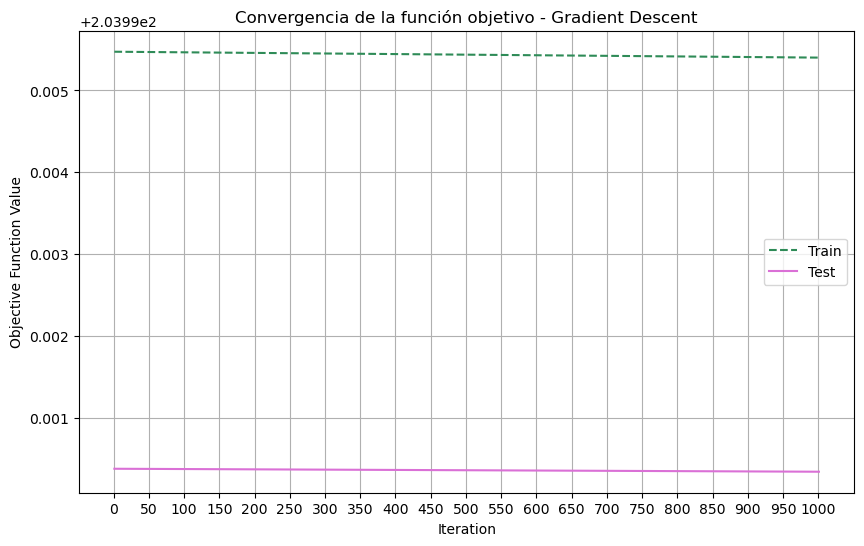

In [198]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(1, len(loss_norm_train) + 1), loss_norm_train, linestyle='--', color='seagreen', label='Train')

plt.plot(np.arange(1, len(loss_norm_test) + 1), loss_norm_test, linestyle='-', color='orchid', label='Test')

tick_interval = max(1, len(loss_norm_train) // 20)
plt.xticks(np.arange(0, len(loss_norm_train) + 1, step=tick_interval))

plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Convergencia de la función objetivo - Gradient Descent')
plt.grid(True)
plt.legend()  
plt.show()

Análisis del parámetro alfa

Ejecutando Gradient Descent con α = 1e-09 y normalizar = True
Criterio de convergencia alcanzado en iteración 0
Ejecutando Gradient Descent con α = 5e-08 y normalizar = True
Ejecutando Gradient Descent con α = 1e-07 y normalizar = True
Ejecutando Gradient Descent con α = 3e-07 y normalizar = True


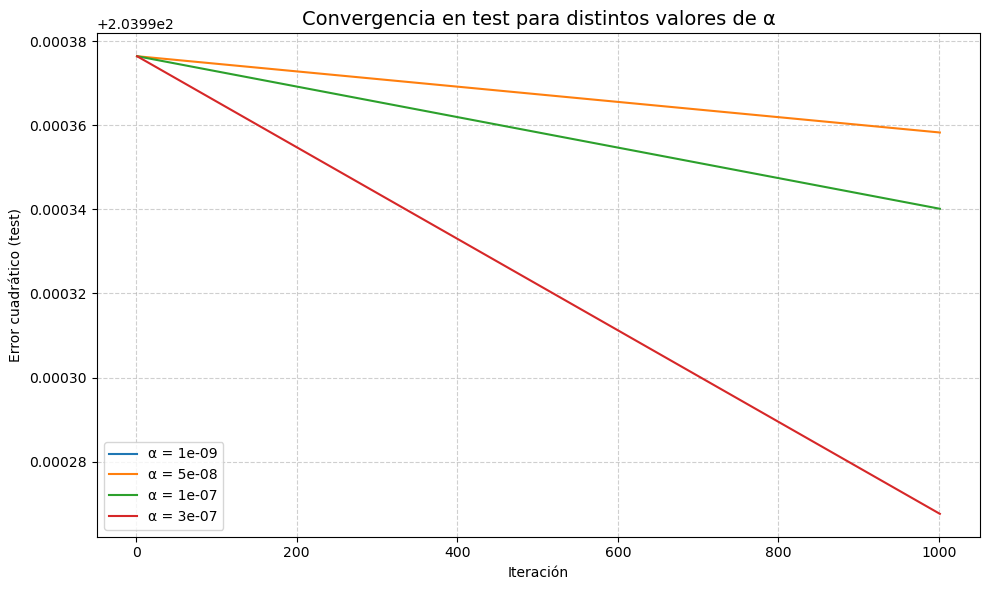

In [199]:
# alphas = [1e-7, 1e-5, 1e-4, 1e-3, 1e-2]  # Valores de alpha a probar
alphas = [1e-9, 5e-8, 1e-7, 3e-7]

loss_train_por_alpha = []  # Lista de listas
loss_test_por_alpha = []  # Lista de listas

for alpha in alphas:
    # Reiniciar pesos para cada experimento
    # w = np.random.uniform(-1, 1, (i_train[0].shape[0], 1)) * 0.01
    # b = np.random.uniform(-1, 1) * 0.01
    # normalizar=False

    print(f"Ejecutando Gradient Descent con α = {alpha} y normalizar = {normalizar}")
   
    w_no_norm_train, b_no_norm_train, loss_no_norm_train, loss_no_norm_test, accuracy_no_norm_train, accuracy_no_norm_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)
    loss_train_por_alpha.append(loss_no_norm_train)
    loss_test_por_alpha.append(loss_no_norm_test)


    # normalizar = True
    # w_norm_train, b_norm_train, loss_norm_train, accuracy_norm_train = gradient_descent(w, b, i_train, d_train, alpha, normalizar)
    
    # Luego evaluamos en test usando los pesos obtenidos
    # w_optimo, b_optimo, loss_test, accuracy_test = gradient_descent(w_no_norm_train, b_no_norm_train, i_test, d_test, alpha, normalizar)
    #  w_no_norm_train, b_no_norm_train, loss_no_norm_train, loss_no_norm_test, accuracy_no_norm_train, accuracy_no_norm_test = gradient_descent(w_no_norm, b, i_train, d_train, i_test, d_test, alpha, normalizar)

    # loss_test_por_alpha.append(loss_test)

plt.figure(figsize=(10, 6))

for i, alpha in enumerate(alphas):
    iteraciones = np.arange(1, len(loss_test_por_alpha[i]) + 1)
    plt.plot(iteraciones, loss_test_por_alpha[i], label=f"α = {alpha}")

plt.title("Convergencia en test para distintos valores de α", fontsize=14)
plt.xlabel("Iteración")
plt.ylabel("Error cuadrático (test)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Análisis del tamaño de escalado de las imágenes

In [200]:
sizes = [muy_chico, chico, mediano, original]
res_train = []
res_test = []
times = []

for size in sizes:
    print(f"\n--- Tamaño de imagen: {size} ---")

    # Cargar imágenes y etiquetas
    i_healthy = image_convert("DatasetTP/Healthy", size)
    d_healthy = np.zeros((i_healthy.shape[0], 1))  # 0 para sanos

    i_park = image_convert("DatasetTP/Parkinson", size)
    d_park = np.ones((i_park.shape[0], 1))  # 1 para Parkinson

    # Dividir en train/test (50/50)
    cant_healthy = i_healthy.shape[0]
    cant_park = i_park.shape[0]

    cant_healthy_train = round(cant_healthy * 0.5)
    cant_park_train = round(cant_park * 0.5)

    # Train
    i_train = np.vstack((i_healthy[:cant_healthy_train], i_park[:cant_park_train]))
    d_train = np.vstack((d_healthy[:cant_healthy_train], d_park[:cant_park_train]))

    # Test
    i_test = np.vstack((i_healthy[cant_healthy_train:], i_park[cant_park_train:]))
    d_test = np.vstack((d_healthy[cant_healthy_train:], d_park[cant_park_train:]))

    # Mezclar
    np.random.seed(42)
    indices = np.random.permutation(i_train.shape[0])
    i_train = i_train[indices]
    d_train = d_train[indices]

    indices = np.random.permutation(i_test.shape[0])
    i_test = i_test[indices]
    d_test = d_test[indices]

    # Inicialización
    # w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.001
    # b = np.random.uniform(-1, 1) * 0.001
    normalizar=False
    alpha = 3e-7

    #gradiente
    start_time = time.time()

    w_opt_train, b_opt_train, valores_loss_train, valores_loss_test, accuracy_train, accuracy_test = gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar)
    # w_opt_test, b_opt_test, test_values, accuracy_test = gradient_descent(w, b, i_train, d_train, alpha, normalizar)
    res_train.append(valores_loss_train)
    res_test.append(valores_loss_test)

    end_time = time.time()
    print(f"Tiempo de ejecución: {end_time - start_time:.2f} segundos")
    times.append(end_time - start_time) 

# Grafico 



--- Tamaño de imagen: (32, 32) ---


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16384 is different from 1024)

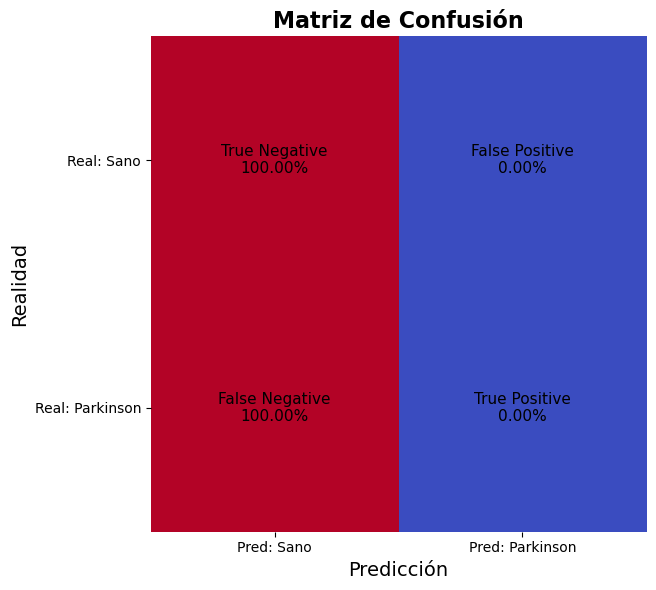

In [ ]:
# Matriz de confusión
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-9 # Mejor alfa encontrado
normalizar = False

w_optimo, b_optimo, loss_no_norm_train, accuracy_no_norm_train = gradient_descent(w, b, i_train, d_train, alpha, normalizar)


# Cálculo de TP, TN, FP y FN para ENTRENAMIENTO

z = i_train @ w_optimo + b_optimo
y_hat = (np.tanh(z) + 1) / 2
y_hat_labels = (y_hat >= 0.5).astype(int)
d_true = d_train.astype(int)

TP_desc_train = np.sum((y_hat_labels == 1) & (d_true == 1))
TN_desc_train = np.sum((y_hat_labels == 0) & (d_true == 0))
FP_desc_train = np.sum((y_hat_labels == 1) & (d_true == 0))
FN_desc_train = np.sum((y_hat_labels == 0) & (d_true == 1))

TP_pct = TP_desc_train / cant_park_train * 100 #sobre el total de gente enferma
TN_pct = TN_desc_train / cant_park_train * 100 #sobre el total de gente sana
FP_pct = FP_desc_train / cant_park_train * 100 #sobre el total de gente sana
FN_pct = FN_desc_train / cant_park_train * 100 #sobre el total de gente enferma

conf_matrix_desc = np.array([[TN_pct, FP_pct],[FN_pct, TP_pct]])

labels = np.array([["True Negative", "False Positive"],
                   ["False Negative", "True Positive"]])

# Generamos texto para cada celda con etiqueta y valor porcentual
annot = np.empty_like(conf_matrix_desc).astype(str)
for i in range(conf_matrix_desc.shape[0]):
    for j in range(conf_matrix_desc.shape[1]):
        annot[i, j] = f"{labels[i, j]}\n{conf_matrix_desc[i, j]:.2f}%"

fig, ax = plt.subplots(figsize=(8, 6))

# Mostrar la matriz como imagen con color
im = ax.imshow(conf_matrix_desc, cmap="coolwarm")

# Ticks de los ejes
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["Pred: Sano", "Pred: Parkinson"])
ax.set_yticklabels(["Real: Sano", "Real: Parkinson"])

# Anotaciones en cada celda
for i in range(conf_matrix_desc.shape[0]):
    for j in range(conf_matrix_desc.shape[1]):
        ax.text(j, i, annot[i, j], ha='center', va='center', color='black', fontsize=11)

# Títulos y etiquetas
ax.set_title("Matriz de Confusión", fontsize=16, weight='bold')
ax.set_xlabel("Predicción", fontsize=14)
ax.set_ylabel("Realidad", fontsize=14)

# Quitar líneas exteriores
for edge, spine in ax.spines.items():
    spine.set_visible(False)

# Opcional: colorbar si querés incluirla
# fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

## Parte 2: Ascenso de gradiente

$$

\arg\min_{\mathbf{w}, b} \mathcal{L}(\mathbf{w}, b) = - \sum_{i=1}^{N} \left[ d_i \log\left( f_{\mathbf{w}, b}(\mathbf{i} * i) \right) + (1 - d_i) \log\left( 1 - f * \mathbf{w}, b(\mathbf{i}_i) \right) \right]


$$

In [ ]:
def fwb_asc(i, w, b):
    z = i@w + b 
    f = 1 / (1 + np.exp(-z))  
    return f

In [ ]:
def funcion_objetivo_asc(w, b, i, d):
    f = fwb_asc(i, w, b)
    epsilon = 1e-15
    f = np.clip(f, epsilon, 1 - epsilon)
    return -np.sum(d * np.log(f) + (1 - d) * np.log(1 - f))  

In [ ]:
def df_w_asc(w, b, i, d):
    f = fwb_asc(i,w,b)              
    error = f - d                
    grad_w = i.T @ error         
    return grad_w

In [ ]:
def df_b_asc(w, b, i, d):
    f = fwb_asc(i,w,b)       
    error = f - d       
    grad_b = np.sum(error)  
    return grad_b

In [ ]:
def accuracy_asc(i, d, w, b):
    f = fwb_asc(i, w, b) 
    y_hat = (f >= 0.5).astype(int)  
    d = d.astype(int)  
    return np.mean(y_hat == d) * 100  

In [ ]:
MAX_ITER = 1000

TOLERANCIA = 1e-7 

def grad_asc(w, b, i_train, i_test, d_train, d_test,alpha):

    i_train = i_train / 255.0
    i_test = i_test / 255.0

    iter = 0
    valores_logv_train = []
    valores_logv_test = []
    accuracy_train = []
    accuracy_test = []

    while iter <= MAX_ITER:

        valores_logv_train.append(funcion_objetivo_asc(w, b, i_train, d_train))
        valores_logv_test.append(funcion_objetivo_asc(w, b, i_test, d_test))

        # Calcular accuracy sobre test (podés hacer también sobre train si querés)
        acc_train = accuracy_desc(i_train, d_train, w, b)
        acc_test = accuracy_desc(i_test, d_test, w, b)
        accuracy_train.append(acc_train)
        accuracy_test.append(acc_test)

        gradiente_w = df_w_asc(w, b, imagenes, diagnosticos)
        gradiente_b = df_b_asc(w, b, imagenes, diagnosticos)

        # Normalización del gradiente si es necesario
        max_norm = 100.0
        norm_w = np.linalg.norm(gradiente_w)
        if norm_w > max_norm:
            gradiente_w = gradiente_w * (max_norm / norm_w)

        if gradiente_b.ndim > 0 and gradiente_b.size > 1:
            gradiente_b = np.mean(gradiente_b)

        # Ascenso
        w_sig = w + alpha * gradiente_w
        b_sig = b + alpha * gradiente_b

        # Convergencia (comparando la pérdida real, no el negativo)
        criterio = np.abs(funcion_objetivo_asc(w_sig, b_sig, imagenes, diagnosticos) -
                          funcion_objetivo_asc(w, b, imagenes, diagnosticos))

        if criterio < TOLERANCIA:
            print("Criterio de convergencia alcanzado en iteración", iter)
            break

        w = w_sig
        b = b_sig
        iter += 1

    return w_sig, b_sig, valores_logv, accuracy


In [ ]:
MAX_ITER = 1000

TOLERANCIA = 1e-8

def gradient_descent(w, b, i_train, d_train, i_test, d_test, alpha, normalizar):
    
  if normalizar:
    i_train = i_train / 255.0
    i_test = i_test / 255.0

  iter  = 0
  valores_loss_train = [] 
  valores_loss_test = []
  accuracy_train = []
  accuracy_test = []


  while iter <= MAX_ITER:

    valores_loss_train.append(funcion_objetivo_desc(w, b, i_train, d_train))
    valores_loss_test.append(funcion_objetivo_desc(w, b, i_test, d_test))

    # Calcular accuracy sobre test (podés hacer también sobre train si querés)
    acc_train = accuracy_desc(i_train, d_train, w, b)
    acc_test = accuracy_desc(i_test, d_test, w, b)
    accuracy_train.append(acc_train)
    accuracy_test.append(acc_test)
        
    gradiente_w = df_w_desc(w, b, i_train, d_train) 
    gradiente_b = df_b_desc(w, b, i_train, d_train)

    # Actualización 
    w_sig = w - alpha * gradiente_w
    b_sig = b - alpha * gradiente_b

    # Criterio de convergencia
    criterio = np.abs(funcion_objetivo_desc(w_sig, b_sig, i_train, d_train) - funcion_objetivo_desc(w, b, i_train, d_train))

    if criterio < TOLERANCIA:
      print("Criterio de convergencia alcanzado en iteración", iter)
      break

    w = w_sig
    b = b_sig
    iter += 1

  return w_sig, b_sig, valores_loss_train, valores_loss_test, accuracy_train, accuracy_test

In [ ]:
w = np.random.uniform(-1, 1, (i_train.shape[1], 1)) * 0.01
b = np.random.uniform(-1, 1) * 0.01
alpha = 1e-5

w_optimo, b_optimo, valores_logv_train, accuracy_train_asc = grad_asc(w, b, i_train, d_train, alpha)

# Cálculo de TP, TN, FP y FN para ENTRENAMIENTO

# z = i_train @ w_optimo + b_optimo
# y_hat = (np.tanh(z) + 1) / 2
# y_hat_labels = (y_hat >= 0.5).astype(int)
# d_true = d_train.astype(int)

# TP_asc_train = np.sum((y_hat_labels == 1) & (d_true == 1))
# TN_asc_train = np.sum((y_hat_labels == 0) & (d_true == 0))
# FP_asc_train = np.sum((y_hat_labels == 1) & (d_true == 0))
# FN_asc_train = np.sum((y_hat_labels == 0) & (d_true == 1))
# Verificá predicciones finales
# z = i_train @ w_optimo + b_optimo
# f = 1 / (1 + np.exp(-z))  # sigmoid
# y_pred = (f >= 0.5).astype(int)

# print("Predicciones:", np.unique(y_pred, return_counts=True))

z = i_train @ w_optimo + b_optimo
f = 1 / (1 + np.exp(-z))

print("f (predicciones sigmoid): min =", np.min(f), "max =", np.max(f))



Iter 0 - LogVeros: 1266.1411 - Accuracy: 50.0000
Iter 50 - LogVeros: 5582.6707 - Accuracy: 50.0000
Iter 100 - LogVeros: 9942.0964 - Accuracy: 50.0000
Iter 150 - LogVeros: 13480.2618 - Accuracy: 50.0000
Criterio de convergencia alcanzado en iteración 169
f (predicciones sigmoid): min = 0.999999999999998 max = 1.0


In [ ]:
print("Max de imágenes:", np.max(i_train))
print("Min de imágenes:", np.min(i_train))


Max de imágenes: 1.0
Min de imágenes: 0.0


In [ ]:
valores, conteos = np.unique(d_train, return_counts=True)
for v, c in zip(valores, conteos):
    print(f"Etiqueta {v}: {c} ejemplos")


Etiqueta 0.0: 408 ejemplos
Etiqueta 1.0: 408 ejemplos


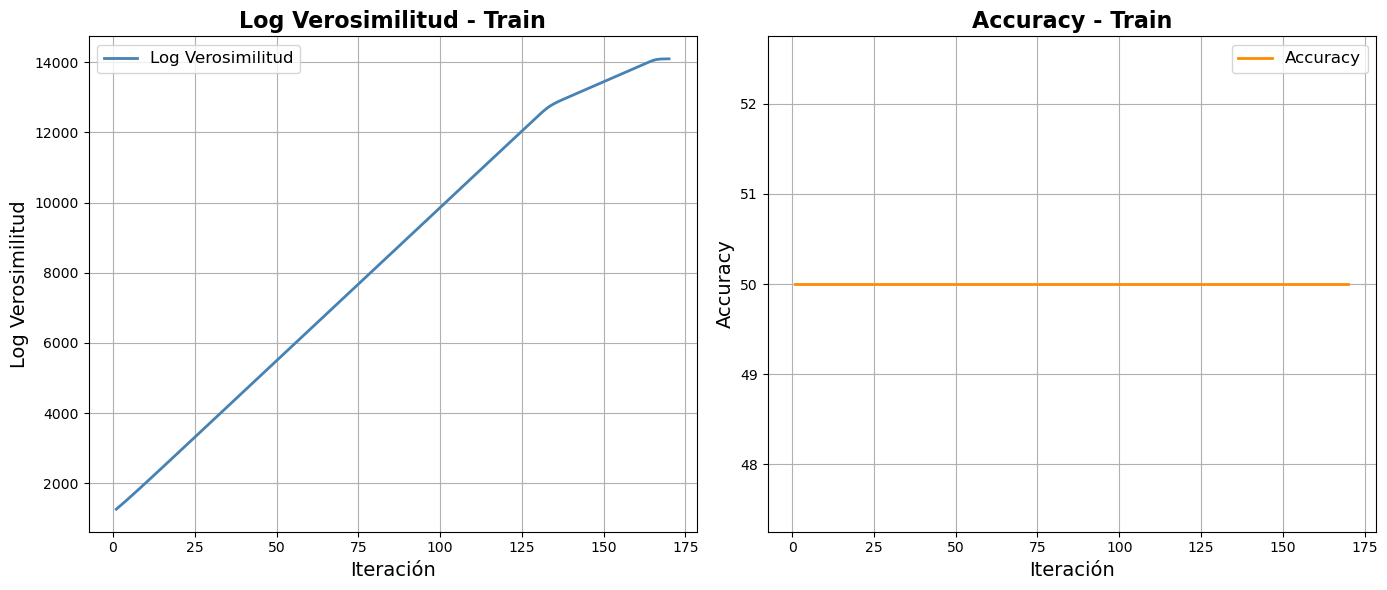

In [ ]:
# sns.set_style("whitegrid")
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# # Error cuadrático
# sns.lineplot(x=np.arange(1, len(valores_logv_train)+1), y=valores_logv_train, ax=axes[0], color='steelblue', linewidth=2, label='Log Verosimilitud')
# axes[0].set_title('Log Verosimilitud - Train', fontsize=16, weight='bold')
# axes[0].set_xlabel('Iteración', fontsize=14)
# axes[0].set_ylabel('Log Verosimilitud', fontsize=14)
# axes[0].legend(fontsize=12)

# # Accuracy
# sns.lineplot(x=np.arange(1, len(accuracy_train_asc)+1), y=accuracy_train_asc, ax=axes[1], color='darkorange', linewidth=2, label='Accuracy')
# axes[1].set_title('Accuracy - Train', fontsize=16, weight='bold')
# axes[1].set_xlabel('Iteración', fontsize=14)
# axes[1].set_ylabel('Accuracy', fontsize=14)
# axes[1].legend(fontsize=12)

# plt.tight_layout()
# plt.show()

import matplotlib.pyplot as plt
import numpy as np

# Suponiendo que ya tenés:
# valores_logv_train → lista de log-verosimilitud por iteración
# accuracy_train_asc → lista de accuracy por iteración

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de Log Verosimilitud
axes[0].plot(np.arange(1, len(valores_logv_train)+1), valores_logv_train,
             color='steelblue', linewidth=2, label='Log Verosimilitud')
axes[0].set_title('Log Verosimilitud - Train', fontsize=16, weight='bold')
axes[0].set_xlabel('Iteración', fontsize=14)
axes[0].set_ylabel('Log Verosimilitud', fontsize=14)
axes[0].legend(fontsize=12)
axes[0].grid(True)

# Gráfico de Accuracy
axes[1].plot(np.arange(1, len(accuracy_train_asc)+1), accuracy_train_asc,
             color='darkorange', linewidth=2, label='Accuracy')
axes[1].set_title('Accuracy - Train', fontsize=16, weight='bold')
axes[1].set_xlabel('Iteración', fontsize=14)
axes[1].set_ylabel('Accuracy', fontsize=14)
axes[1].legend(fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

